In [225]:
#!g1.1
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [226]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Обучение seq2seq на коротких англо-русских парах фраз

Подготовим данные, обучим GRU модели, попробуем увеличить число рекуррентных слоев и проверим LSTM в этой задаче

### Подготовка пар

Читаем пары из файла, нормализуем их, и с помощью объектов-словарей создаем наборы для обучения


In [227]:
#!g1.1
# Объявляем класс для операций со словарями языка

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [228]:
#!g1.1
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r'[^a-zа-яё ]', '', s)
    return s.strip()

In [229]:
#!g1.1
# Объявим функцию, генерирующую классы-словари по данным из файла
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [230]:
#!g1.1
MAX_LENGTH = 10

eng_prefixes = (
    "i ", 
    "he ", 
    "she ", 
    "you ", 
    "we ", 
    "they "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [231]:
#!g1.1
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 487600 sentence pairs
Trimmed to 135200 sentence pairs
Counting words...
Counted words:
rus 25317
eng 8771
['он помолвлен с моей сестрой', 'he is engaged to my sister']


### Объявляем классы энкодера и декодера
Пока на основе GRU архитектуры

In [232]:
#!g1.1
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [233]:
#!g1.1
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

### Подготавливаем данные для обучения

Преобразуем фразы в тензоры с помощью словарей, объявляем функции для обучения и инференса

In [258]:
#!g1.1
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [235]:
#!g1.1
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [236]:
#!g1.1
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [237]:
#!g1.1
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    plot_acc = []
    print_loss_total = 0  # Reset every print_every
    print_acc_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_acc_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(pairs) for i in range(n_iters)]
    training_tensors = [tensorsFromPair(pair) for pair in training_pairs]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_tensors[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        input_sentence = training_pairs[iter - 1][0]
        predicted_sentence = ' '.join([word for word in evaluate(encoder, decoder, input_sentence) if word != '<EOS>'])
        predicted_tensor = tensorFromSentence(output_lang, predicted_sentence)
        min_len = min(predicted_tensor.shape[0], target_tensor.shape[0])
        acc = np.mean(predicted_tensor.cpu().numpy()[0:min_len] == target_tensor.cpu().numpy()[0:min_len])
        print_acc_total += acc
        plot_acc_total += acc

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_acc_avg = print_acc_total / print_every
            print_acc_total = 0
            print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, print_acc_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            plot_acc_avg = plot_acc_total / plot_every
            plot_acc.append(plot_acc_avg)
            plot_acc_total = 0

    showPlot(plot_losses)
    
    return plot_losses, plot_acc

In [238]:
#!g1.1
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [239]:
#!g1.1
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [240]:
#!g1.1
def evaluateRandomly(encoder, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Обучаем GRU модели
Для одного, двух и трех последовательных блоков

1m 42s (- 23m 58s) (5000 6%) 4.0959 0.3252
3m 20s (- 21m 44s) (10000 13%) 3.5117 0.4337
5m 0s (- 20m 0s) (15000 20%) 3.2627 0.4855
6m 40s (- 18m 20s) (20000 26%) 3.0635 0.5344
8m 20s (- 16m 41s) (25000 33%) 2.8708 0.5705
10m 1s (- 15m 1s) (30000 40%) 2.7441 0.6063
11m 42s (- 13m 22s) (35000 46%) 2.6085 0.6331
13m 24s (- 11m 43s) (40000 53%) 2.5718 0.6434
15m 5s (- 10m 3s) (45000 60%) 2.4951 0.6622
16m 46s (- 8m 23s) (50000 66%) 2.4249 0.6728
18m 28s (- 6m 43s) (55000 73%) 2.3666 0.6868
20m 11s (- 5m 2s) (60000 80%) 2.3312 0.6909
21m 53s (- 3m 22s) (65000 86%) 2.2483 0.7138
23m 35s (- 1m 41s) (70000 93%) 2.2225 0.7171
25m 18s (- 0m 0s) (75000 100%) 2.1900 0.7200


<Figure size 432x288 with 0 Axes>

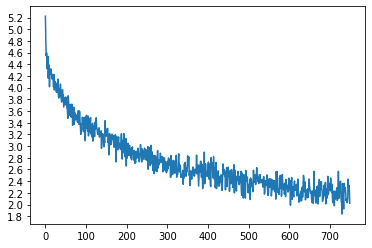

In [241]:
#!g1.1
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses_1, acc_1 = trainIters(encoder, decoder, 75000, print_every=5000)

In [242]:
#!g1.1
evaluateRandomly(encoder, decoder)

> она не хотела раскрывать свой секрет
= she was reluctant to reveal her secret
< she didnt want to give up <EOS>

> я никого здесь не знаю
= i dont know anyone here
< i dont know anyone here <EOS>

> вероятно он не придёт
= he probably wont come
< he didnt not come <EOS>

> он на коне
= he is on a roll
< he was on a <EOS>

> я сказала бросьте ружьё
= i said drop your gun
< i was your <EOS>



1m 54s (- 26m 46s) (5000 6%) 4.0798 0.3306
3m 44s (- 24m 18s) (10000 13%) 3.5473 0.4223
5m 37s (- 22m 29s) (15000 20%) 3.3101 0.4762
7m 29s (- 20m 37s) (20000 26%) 3.1347 0.5217
9m 23s (- 18m 47s) (25000 33%) 2.9396 0.5618
11m 17s (- 16m 56s) (30000 40%) 2.8325 0.5958
13m 11s (- 15m 4s) (35000 46%) 2.6867 0.6270
15m 4s (- 13m 11s) (40000 53%) 2.5888 0.6484
16m 59s (- 11m 19s) (45000 60%) 2.4815 0.6646
18m 52s (- 9m 26s) (50000 66%) 2.4429 0.6775
20m 46s (- 7m 33s) (55000 73%) 2.3750 0.6938
22m 40s (- 5m 40s) (60000 80%) 2.3316 0.7075
24m 35s (- 3m 47s) (65000 86%) 2.2251 0.7244
26m 32s (- 1m 53s) (70000 93%) 2.1919 0.7296
28m 27s (- 0m 0s) (75000 100%) 2.1772 0.7409


<Figure size 432x288 with 0 Axes>

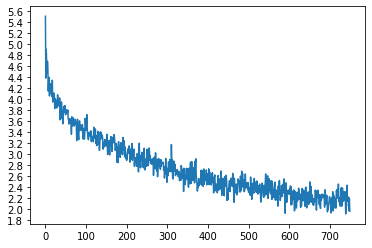

In [243]:
#!g1.1
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, 2).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words, 2).to(device)

losses_2, acc_2 = trainIters(encoder, decoder, 75000, print_every=5000)

In [244]:
#!g1.1
evaluateRandomly(encoder, decoder)

> я знаю что вы этого почти никогда не делаете
= i know that you hardly ever do that
< i know that you dont do <EOS>

> я не люблю больницы
= i dont like hospitals
< i dont like to <EOS>

> ты можешь сесть
= you may sit down
< you can sit <EOS>

> я поняла что не готова
= i realized i wasnt ready
< i dont think im ready <EOS>

> я хочу объяснить
= i want to explain
< i want to explain <EOS>



2m 8s (- 29m 58s) (5000 6%) 4.1758 0.3247
4m 12s (- 27m 24s) (10000 13%) 3.6844 0.4021
6m 15s (- 25m 3s) (15000 20%) 3.4054 0.4580
8m 19s (- 22m 53s) (20000 26%) 3.2219 0.5010
10m 24s (- 20m 48s) (25000 33%) 3.0655 0.5381
12m 29s (- 18m 43s) (30000 40%) 2.9359 0.5707
14m 33s (- 16m 38s) (35000 46%) 2.8312 0.6004
16m 40s (- 14m 35s) (40000 53%) 2.7338 0.6235
18m 47s (- 12m 31s) (45000 60%) 2.6413 0.6436
20m 55s (- 10m 27s) (50000 66%) 2.5788 0.6596
23m 1s (- 8m 22s) (55000 73%) 2.4898 0.6784
25m 8s (- 6m 17s) (60000 80%) 2.4392 0.6880
27m 16s (- 4m 11s) (65000 86%) 2.3524 0.7018
29m 23s (- 2m 5s) (70000 93%) 2.2995 0.7158
31m 31s (- 0m 0s) (75000 100%) 2.2752 0.7263


<Figure size 432x288 with 0 Axes>

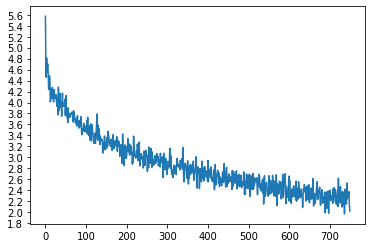

In [245]:
#!g1.1
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, 3).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words, 3).to(device)

losses_3, acc_3 = trainIters(encoder, decoder, 75000, print_every=5000)

In [246]:
#!g1.1
evaluateRandomly(encoder, decoder)

> не думаю что мне бы понравилось этим заниматься
= i dont think id like doing that
< i dont think i would do this <EOS>

> у них ничего не осталось
= they have nothing left
< they didnt have anything <EOS>

> надеюсь вы не такая как все
= i hope that youre not like everybody else
< i hope you you not like <EOS>

> я не мог уснуть прошлой ночью
= i couldnt sleep last night
< i couldnt sleep last night <EOS>

> вам не стоит слушать тома
= you shouldnt listen to tom
< you shouldnt let tom go <EOS>



### Объявляем классы энкодера и декодера
Теперь на основе LSTM архитектуры (добавляетя cell-state)

In [247]:
#!g1.1
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device), torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
    
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device), torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

### Обучаем LSTM модели
Для одного, двух и трех последовательных блоков

1m 43s (- 24m 13s) (5000 6%) 4.2003 0.2730
3m 22s (- 21m 56s) (10000 13%) 3.7763 0.3676
5m 3s (- 20m 13s) (15000 20%) 3.5180 0.4273
6m 43s (- 18m 30s) (20000 26%) 3.3318 0.4707
8m 25s (- 16m 51s) (25000 33%) 3.1426 0.5009
10m 7s (- 15m 11s) (30000 40%) 3.0029 0.5315
11m 50s (- 13m 31s) (35000 46%) 2.9379 0.5467
13m 34s (- 11m 52s) (40000 53%) 2.8201 0.5677
15m 16s (- 10m 10s) (45000 60%) 2.7283 0.5833
16m 58s (- 8m 29s) (50000 66%) 2.6431 0.6034
18m 41s (- 6m 47s) (55000 73%) 2.6329 0.6018
20m 25s (- 5m 6s) (60000 80%) 2.5165 0.6235
22m 8s (- 3m 24s) (65000 86%) 2.4699 0.6374
23m 53s (- 1m 42s) (70000 93%) 2.4297 0.6438
25m 37s (- 0m 0s) (75000 100%) 2.3834 0.6488


<Figure size 432x288 with 0 Axes>

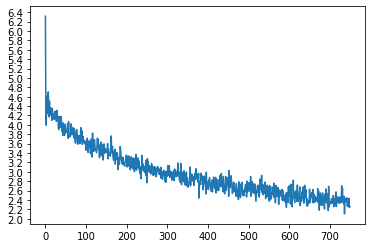

In [248]:
#!g1.1
hidden_size = 256
encoder = EncoderLSTM(input_lang.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words).to(device)

losses_1_lstm, acc_1_lstm = trainIters(encoder, decoder, 75000, print_every=5000)

1m 54s (- 26m 41s) (5000 6%) 4.2760 0.2843
3m 46s (- 24m 35s) (10000 13%) 3.9172 0.3419
5m 39s (- 22m 39s) (15000 20%) 3.6878 0.3840
7m 33s (- 20m 46s) (20000 26%) 3.4864 0.4267
9m 26s (- 18m 52s) (25000 33%) 3.3653 0.4561
11m 20s (- 17m 1s) (30000 40%) 3.2224 0.4868
13m 14s (- 15m 8s) (35000 46%) 3.1026 0.5056
15m 9s (- 13m 15s) (40000 53%) 2.9981 0.5294
17m 4s (- 11m 22s) (45000 60%) 2.8912 0.5589
19m 0s (- 9m 30s) (50000 66%) 2.8091 0.5749
20m 56s (- 7m 36s) (55000 73%) 2.7287 0.5951
22m 53s (- 5m 43s) (60000 80%) 2.6418 0.6109
24m 50s (- 3m 49s) (65000 86%) 2.5725 0.6281
26m 46s (- 1m 54s) (70000 93%) 2.5343 0.6351
28m 43s (- 0m 0s) (75000 100%) 2.4624 0.6516


<Figure size 432x288 with 0 Axes>

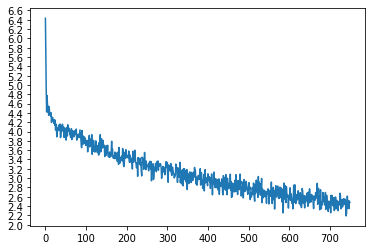

In [249]:
#!g1.1
hidden_size = 256
encoder = EncoderLSTM(input_lang.n_words, hidden_size, 2).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words, 2).to(device)

losses_2_lstm, acc_2_lstm = trainIters(encoder, decoder, 75000, print_every=5000)

2m 16s (- 31m 50s) (5000 6%) 4.4317 0.2520
4m 21s (- 28m 22s) (10000 13%) 4.0112 0.3157
6m 26s (- 25m 45s) (15000 20%) 3.8881 0.3402
8m 31s (- 23m 27s) (20000 26%) 3.6993 0.3752
10m 37s (- 21m 14s) (25000 33%) 3.6057 0.3976
12m 44s (- 19m 6s) (30000 40%) 3.4795 0.4245
14m 50s (- 16m 57s) (35000 46%) 3.3764 0.4482
16m 55s (- 14m 48s) (40000 53%) 3.2733 0.4670
19m 2s (- 12m 41s) (45000 60%) 3.1959 0.4827
21m 9s (- 10m 34s) (50000 66%) 3.0910 0.5101
23m 17s (- 8m 28s) (55000 73%) 3.0010 0.5227
25m 25s (- 6m 21s) (60000 80%) 2.9329 0.5386
27m 32s (- 4m 14s) (65000 86%) 2.8977 0.5486
29m 40s (- 2m 7s) (70000 93%) 2.8224 0.5656
31m 48s (- 0m 0s) (75000 100%) 2.7206 0.5851


<Figure size 432x288 with 0 Axes>

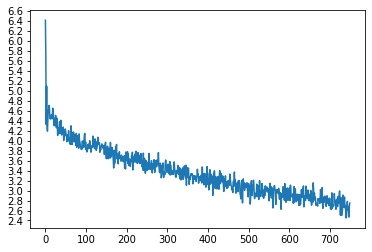

In [251]:
#!g1.1
hidden_size = 256
encoder = EncoderLSTM(input_lang.n_words, hidden_size, 3).to(device)
decoder = DecoderLSTM(hidden_size, output_lang.n_words, 3).to(device)

losses_3_lstm, acc_3_lstm = trainIters(encoder, decoder, 75000, print_every=5000)

### Сравнительные графики
Точность от количества последовательных рекуррентных ячеек, точность от типа рекуррентной ячейки

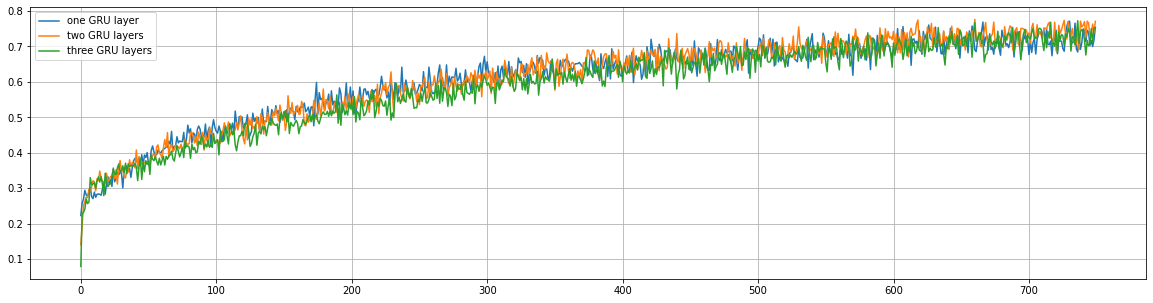

In [254]:
#!g1.1
plt.figure(figsize=(20, 5))
plt.plot(acc_1, label='one GRU layer')
plt.plot(acc_2, label='two GRU layers')
plt.plot(acc_3, label='three GRU layers')
plt.grid()
plt.legend()
plt.show()

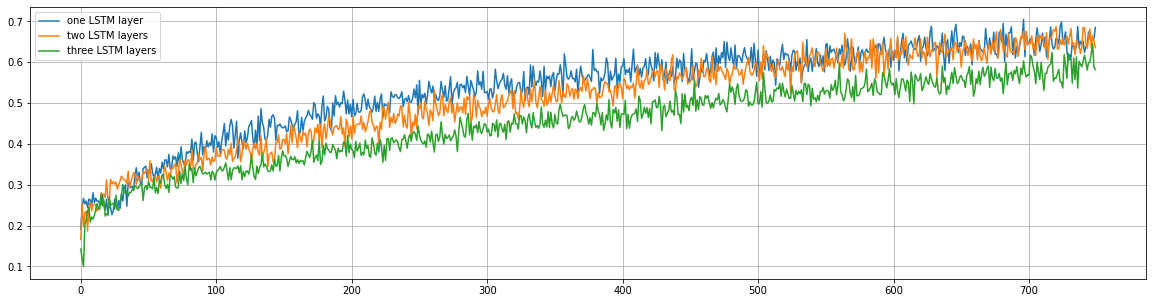

In [255]:
#!g1.1
plt.figure(figsize=(20, 5))
plt.plot(acc_1_lstm, label='one LSTM layer')
plt.plot(acc_2_lstm, label='two LSTM layers')
plt.plot(acc_3_lstm, label='three LSTM layers')
plt.grid()
plt.legend()
plt.show()

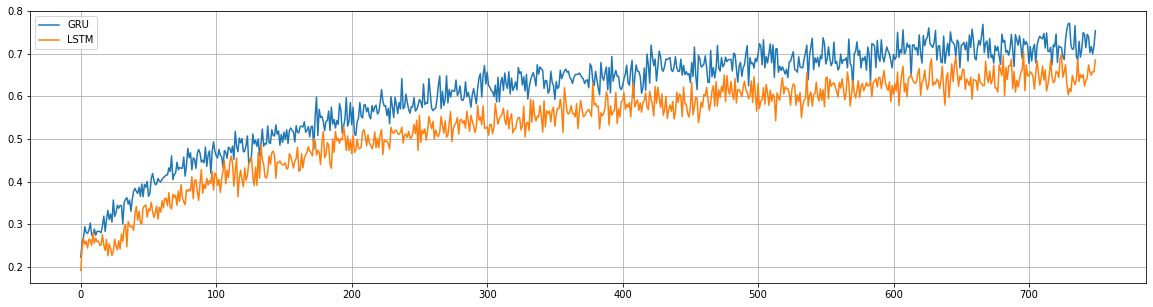

In [256]:
#!g1.1
plt.figure(figsize=(20, 5))
plt.plot(acc_1, label='GRU')
plt.plot(acc_1_lstm, label='LSTM')
plt.grid()
plt.legend()
plt.show()

### Итого

1) Добавление одного рекуррентного слоя позволяет немного улучшить итоговую точность модели (на 3-4%) в случае с GRU архитектурой. Для LSTM выигрыша в данных условиях не увидели.
2) На данном тренировочном наборе и длительности обучения GRU значительно эффективнее LSTM.

#### Почему

Все зависит от конкретной задачи и данных, на которых модель обучается. В некоторых случаях GRU может работать лучше, чем LSTM, потому что он имеет меньше параметров и может быть более эффективным на небольших данных. Это наш случай: 
1. Данных мало
2. Последовательности короткие

Однако, в других случаях LSTM может быть более подходящим выбором из-за своей способности к долгосрочной зависимости и более сложной архитектуре. В целом, выбор между GRU и LSTM зависит от конкретной задачи и необходимо провести эксперименты, чтобы определить, какая модель работает лучше на конкретных данных. В этом случае - GRU.

In [ ]:
#!g1.1
